In [6]:
import numpy as np
import itertools
import datetime

import tensorflow as tf
import sklearn as sk

from gensim.models import Word2Vec

import Functions as fn
import Iterator as it
from DS import DS
from Set import pool
from FFModel import FF_Model
from RNNModel import RNN_Model

# Data Loading

In [7]:
Dataset = pool()
Dataset.load_texts('raw_texts')
Dataset.load_labels('raw_labels')

Raw Text Load Complete
Raw Labels Load Complete


In [8]:
target_dict = fn.load_labels('labels')

Label Load Complete


# Embedding Generation

In [9]:
#Dataset.process_for_embedding()
#sentences = Dataset.get_sentences()
#fn.write_sentences('sentences')
sentences = fn.load_sentences('sentences')

#model = Word2Vec(sentences, min_count=1, size=100)
#model.save('W2V')
model = Word2Vec.load('W2V')

vocab = model.wv.vocab.keys()

Sentence Load Complete


# Layer and Index Loading

In [10]:
#word_indices, emb_layer = fn.get_index_and_emb_layer(model)
#fn.write_word_indices(word_indices, 'word_indices')
#fn.write_emb_layer(emb_layer, 'emb_layer')

word_indices = fn.load_word_indices('word_indices')
emb_layer = fn.load_emb_layer('emb_layer')

Word Indices Load Complete
Embedding Layer Load Complete


# RNN Testing

In [11]:
target = 'r'

train_cases = pool((Dataset.get_DS(stage='test', labelled='yes')).data[:-25])
validation_cases = pool(Dataset.get_DS(stage='test', labelled='yes').data[-25:])
test_cases = Dataset.get_DS(stage='train', labelled='yes')

train_cases.process_for_testing(target)
validation_cases.process_for_testing(target)
test_cases.process_for_testing(target)

In [12]:
lw, rw = 4, 4
sets = {}
sets['train_set'], sets['train_labels'], _, sets['train_lengths'] = train_cases.get_rnn_sets(word_indices, lw, rw)
sets['validation_set'], sets['validation_labels'], _, sets['validation_lengths']= validation_cases.get_rnn_sets(word_indices, lw, rw)
sets['test_set'], sets['test_labels'], sets['test_words'], sets['test_lengths'] = test_cases.get_rnn_sets(word_indices, lw, rw)

In [14]:
print('Ratio: med: {:.2f}% non-med: {:.2f}%'.format(*(np.array(sets['train_labels']).sum(0)/ len(sets['train_labels']))))
fn.saturate_training_set(sets, 0.1, seqlen=True)
print('Ratio: med: {:.2f}% non-med: {:.2f}%'.format(*(np.array(sets['train_labels']).sum(0)/ len(sets['train_labels']))))

Ratio: med: 0.01% non-med: 0.99%
Ratio: med: 0.10% non-med: 0.90%


C:\Users\Luka\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


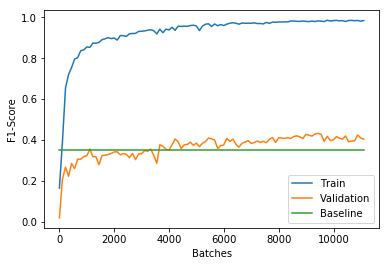

FInal Values: Tr-F1: 0.9839, Val-F1: 0.4038
Test F1-Score: 0.2973



In [15]:
RNN = RNN_Model(vocab_size=len(word_indices), state_size=100, num_classes=2, learn_rate=0.001, emb_layer=emb_layer)
RNN.build_graph()
results_list = RNN.train(sets=sets, epochs=2, batch=50, report_percentage=1, show_progress=True, show_plot=True)

In [16]:
res = RNN.predict(sets['test_set'], sets['test_lengths'])
tru = np.argmax(sets['test_labels'], 1)

In [17]:
token_perf = fn.token_perf(res, tru)

TP	TN	FP	FN
33	10972	70	86

Precision: 0.3204
Recall: 0.2773
F1-Score: 0.2973


In [18]:
baseline = [0 if word in target_dict['reasons'] else 1 for word in sets['test_words']]
sk.metrics.f1_score(tru, baseline, pos_label=0, average='binary')

0.07129996398991717

In [19]:
fn.category_words(sets['test_words'], res, tru, 1, 0)

two, <num>%, stenosis, in, a, long, segment, of, the, left, sfa, and, the, left, distal, sfa, and, anterior, tibial, vein, graft, was, completely, thrombosed, reserve, patency, of, her, graft, tachycardia, saturations, diuresis, left, jaw, pain, jaw, jaw, pain, chest, pain, drop, in, blood, count, hematoma, had, a, temperature, to, about, <num>, pain, to, reduce, perioperative, mi, risk, phantom, limb, pain, for, ventricular, tachycardia, hyperthyroidism, hypothyroidism, anticoagulation, behavior, pneumonia, blood, sugar, blood, blood, sugar, blood, sugar, headache, temperature, bilateral, lower, extremity, swelling, hf, symptoms, diuresed, swelling, swelling


In [20]:
fn.colour_text(sets['test_words'], res, tru)

record #<num> <num> | tmh | <num> | | <num> | <num>/<num>/<num> <num>:<num>:<num> am | discharge summary | signed | dis | admission date <num>/<num>/<num> report status signed discharge date <num>/<num>/<num> history ms pizzo is a <num>-year-old woman with peripheral vascular disease who recently underwent revision of her left superior femoral artery anterior tibial bypass graft , who now presents with a cool , ischemic left foot mrs denman is a <num>-year-old , insulin-dependent diabetic with a long history of peripheral vascular disease as well as multiple surgical procedures she underwent a right transmetatarsal amputation in <num> and subsequently underwent a right femorla distal saphenous vein bypass graft in <num> which was later revised in <num>. she seems to be doing well with the left side until july of this year , at which time she underwent a left superficial femoral artery to anterior tibial artery bypass using non-reversed basilic vein harvested from the right arm she , ho

In [21]:
testers = Dataset.get_DS(stage='train', labelled='yes')
phrase_perf = fn.phrase_perf(target, RNN, testers, word_indices, side_words=[lw, rw], tfpn=True, show_phrases=True, case_info=True, rnn=True)

Name:  0101
Challenge:  2009 Medication Challenge
Train or Test Set:  train
Labelled:  yes
Labeling Type:  train


an 1 0
left 1 0
reserve patency of her graft 0 1
toe wound 1 0
two <num>% stenosis in a long segment of the left sfa and the left distal sfa and anterior tibial vein graft was completely thrombosed 0 1

Name:  0102
Challenge:  2009 Medication Challenge
Train or Test Set:  train
Labelled:  yes
Labeling Type:  train


a positive urinary tract infection 1 0
diuresis 1 2
mr 1 0
pain 1 1
positive urinary tract infection 0 1
saturations 0 1
tachycardia 0 1

Name:  0105
Challenge:  2009 Medication Challenge
Train or Test Set:  train
Labelled:  yes
Labeling Type:  train


anginal pain 1 0
anticoagulation 1 0
bleeding her headache 1 0
blood loss 0 1
cardiac catheterization 1 0
chest pain 0 1
drop in blood count 0 1
headache 0 1
hematoma 0 1
hematoma continued to expand 0 1
her 2 0
jaw pain 0 2
jaw the pain 1 0
left jaw pain 0 1
pain 1 0
possible bleeding disorder 1 0
upper extremit

# HyperParameter Scan

In [ ]:
emb_sizes = [100]
emb_models = 1
target_saturations = [0.05, 0.1, 0.2, 0.5, 0.7]
layer_sizes = [50]
dropouts = [1.0]
learn_rates = [0.01]
epochs = [100]
NN_num = 5

case_num = len(emb_sizes)*emb_models*len(layer_sizes)*len(target_saturations)*len(epochs)*len(dropouts)*len(learn_rates)*NN_num
print(case_num)

In [ ]:
max_performance = 0
n = 1

for emb_size in emb_sizes:
    print('Model Number: %d/%d' %(n, case_num))
    for i in range(emb_models):
        model = Word2Vec(sentences, min_count=1, size=emb_size)
        for saturation in target_saturations:
            sets = fn.get_traintest2 (labelled_cases, model)
            fn.saturate_training_set(sets, model, target_dict['medications'], saturation)
            for layer_size in layer_sizes:
                for drop in dropouts:
                    for rate in learn_rates:
                        for epoch in epochs:
                            for j in range(NN_num):
                                print('Model Number: %d/%d' %(n, case_num))
                                print('ES: %d EM: %d sat: %f, LS: %d, drop: %f, LR: %f, epochs: %d, NN: %d' \
                                       % (emb_size, i, saturation, layer_size, drop, rate, epoch, j))
                                NN = FF_Model(input_size=emb_size, layers=[layer_size], dropout=drop, learn_rate=rate)
                                NN.build_graph()
                                NN.train(sets, epochs=epoch)
                                res = NN.predict(sets['test_set'])
                                tru = np.argmax(sets['test_labels'], 1)
                                perf = sk.metrics.f1_score(tru, res, pos_label=0)
                                if perf > max_performance:
                                    max_performance = perf
                                    NN.save_model('gold')
                                    model.save('gold/GOLDEMB')
                                NN.close()
                                n += 1